In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob

import cftime
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cmocean

import cartopy
import cartopy.crs as ccrs

import util
import oae_smyle

In [3]:
caselist = [
    'smyle-fosi.regional.lat-range-basin.000',
]

dsets = {}
for case in caselist:
    member_id = case.split('.')[-1]
    dsets[member_id] = oae_smyle.open_dataset(
        case=case,
        stream='pop.h',
    )

dsets

{'000': <xarray.Dataset>
 Dimensions:                          (time: 144, d2: 2, moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320)
 Coordinates: (12/15)
     transport_components             (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
     transport_regions                (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
   * time                             (time) object 0347-01-16 12:00:00 ... 03...
   * z_t                              (z_t) float32 500.0 1.5e+03 ... 5.375e+05
   * z_t_150m                         (z_t_150m) float32 500.0 ... 1.45e+04
   * z_w                              (z_w) float32 0.0 1e+03 ... 5e+05 5.25e+05
     ...                               ...
   * moc_z                            (moc_z) float32 0.0 1e+03 ... 5.5e+05
     TLONG                            (nlat, nlon) float64 320.6 321.7 ... 319.8
     TLA

In [4]:
with xr.set_options(keep_attrs=True):
    flux_baseline = dsets['000'].FG_ALT_CO2 * oae_smyle.nmolcm2s_to_molm2yr
    flux_baseline.attrs['units'] = 'mol m$^{-2}$ yr$^{-1}$'
    flux_baseline = (-1.0) * flux_baseline.weighted(dsets['000'].time_delta).mean('time').compute()


flux_effect = oae_smyle.time_integral(
    oae_smyle.compute_flux_effect(dsets['000']),
    convert_time=1.0 / 365.0
).compute()

alk_excess = oae_smyle.compute_alk_excess_100m(dsets['000']).compute()
flux_effect

<xarray.DataArray (nlat: 384, nlon: 320)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00016752, -0.00027886, -0.0003526 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    KMT      (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    area_m2  (nlat, nlon) float64 1.125e+09 1.125e+09 1.124e+09 ... nan nan nan
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:        DIC Surface Gas Flux
    units:            mol m$^{-2}$ 
    grid_loc:         2110
    cell_methods:     time: mean
    sign_convention:  postive up

In [5]:
ds = dsets["000"]

with xr.set_options(keep_attrs=True):
    alk_flux_tint = (
        ds.ALK_FLUX.weighted(ds.time_delta * 86400.0).sum("time")
        * oae_smyle.nmolcm2_to_molm2
    )
    alk_flux_tint.attrs['units'] = 'mol m$^{-2}$'
    alk_flux_tint = alk_flux_tint.compute()

alk_flux_tint

<xarray.DataArray 'ALK_FLUX' (nlat: 384, nlon: 320)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    KMT      (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TAREA    (nlat, nlon) float64 1.125e+13 1.125e+13 1.124e+13 ... nan nan nan
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Flux of Alk from forcing data
    units:         mol m$^{-2}$
    grid_loc:      2110
    cell_methods:  time: mean

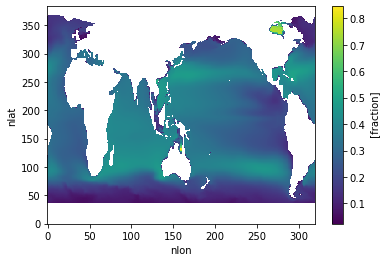

In [6]:
year_last = dsets['000'].time.values[-1].year
alk_year_last = alk_excess.sel(time=f'{year_last:04d}').weighted(dsets['000'].time_delta).mean('time')

alk_fraction_retained = alk_year_last / alk_flux_tint.where(alk_flux_tint > 0)
alk_fraction_retained.attrs['units'] = 'fraction'

alk_fraction_retained = alk_fraction_retained.compute()
alk_fraction_retained.plot()

In [8]:
dsa = util.pop_add_cyclic(
    xr.Dataset(
        dict(
            flux_baseline=flux_baseline,
            flux_effect=flux_effect,
            alk_fraction_retained=alk_fraction_retained,
        )
    )
)
dsa

<xarray.Dataset>
Dimensions:                (nlat: 384, nlon: 321)
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT                   (nlat, nlon) float64 -79.22 -79.22 ... 80.31 80.31
    TLONG                  (nlat, nlon) float64 -220.6 -219.4 ... -39.57 -39.86
    flux_baseline          (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    flux_effect            (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    alk_fraction_retained  (nlat, nlon) float64 nan nan nan nan ... nan nan nan

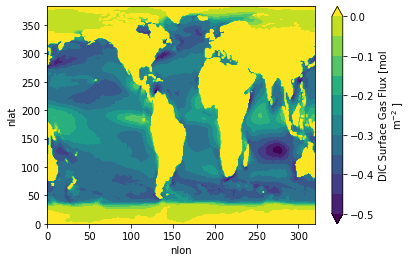

In [9]:
dsa.flux_effect.plot.contourf(levels=np.arange(-0.5, 0.05, 0.05))

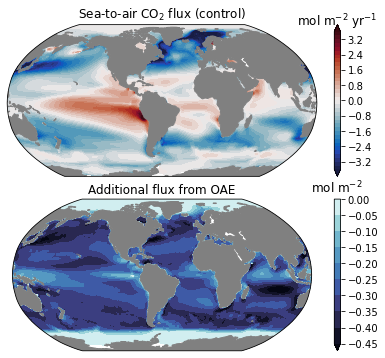

In [10]:
fig = plt.figure(figsize=(6, 6))
prj = ccrs.Robinson(central_longitude=305.0)

gs = gridspec.GridSpec(
    nrows=2, ncols=2,
    width_ratios=(1, 0.02),
    wspace=0.1,
    hspace=0.15,
)

axs_map = [
    plt.subplot(gs[0, 0], projection=prj),
    plt.subplot(gs[1, 0], projection=prj),
]
caxs = [
    plt.subplot(gs[0, -1]),
    plt.subplot(gs[1, -1]),
]

cmap = dict(
    flux_baseline=cmocean.cm.balance,
    flux_effect=cmocean.cm.ice,
)

levels = dict(
    flux_baseline=np.arange(-3.6, 3.8, 0.2),
    flux_effect=np.arange(-0.45, 0.05, 0.05),
)
extend = dict(
    flux_baseline='both',
    flux_effect='min',
)

title = dict(
    flux_baseline='Sea-to-air CO$_2$ flux (control)',
    flux_effect='Additional flux from OAE',
)

n = 0
for field, ax in zip(['flux_baseline', 'flux_effect'], axs_map):

    levels_f = levels[field]
    cf = ax.contourf(
        dsa.TLONG, dsa.TLAT, dsa[field],
        levels=levels_f,
        extend=extend[field],
        cmap=cmap[field],
        transform=ccrs.PlateCarree(),
    )

    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            'physical', 'land', '110m',
            edgecolor='face',
            facecolor='gray'
        )
    )

    plt.colorbar(cf, cax=caxs[n])
    caxs[n].set_title(dsa[field].attrs['units'])

    ax.set_title(title[field])
    n += 1

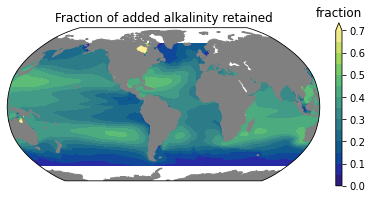

In [11]:
fig = plt.figure(figsize=(6, 3))
prj = ccrs.Robinson(central_longitude=305.0)

gs = gridspec.GridSpec(
    nrows=1, ncols=2,
    width_ratios=(1, 0.02),
    wspace=0.1,
    hspace=0.15,
)

axs_map = [
    plt.subplot(gs[0, 0], projection=prj),
]
caxs = [
    plt.subplot(gs[0, -1]),
]

cmap = dict(
    alk_fraction_retained=cmocean.cm.haline,
)

levels = dict(
    alk_fraction_retained=np.arange(0., 0.75, 0.05),
)
extend = dict(
    alk_fraction_retained='max',
)

title = dict(
    alk_fraction_retained='Fraction of added alkalinity retained',
)

n = 0
for field, ax in zip(['alk_fraction_retained'], axs_map):

    levels_f = levels[field]
    cf = ax.contourf(
        dsa.TLONG, dsa.TLAT, dsa[field],
        levels=levels_f,
        extend=extend[field],
        cmap=cmap[field],
        transform=ccrs.PlateCarree(),
    )

    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            'physical', 'land', '110m',
            edgecolor='face',
            facecolor='gray'
        )
    )

    plt.colorbar(cf, cax=caxs[n])
    caxs[n].set_title(dsa[field].attrs['units'], y=1.05)

    ax.set_title(title[field])
    n += 1

In [21]:
for v in dsets['000'].data_vars:
    if 'co3' in v.lower():
        print(v)

CaCO3_form_zint
CaCO3_form_zint_100m
CO3
HCO3
H2CO3
CO3_ALT_CO2
co3_sat_calc
co3_sat_arag
CaCO3_FLUX_100m
CaCO3_PROD_zint
CaCO3_PROD_zint_100m
CaCO3_REMIN_zint
CaCO3_REMIN_zint_100m
spCaCO3


<xarray.DataArray 'CO3' (time: 144, z_t: 60, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(144, 60, 384, 320), dtype=float32, chunksize=(1, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) object 0347-01-16 12:00:00 ... 0358-12-16 12:00:00
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    TLONG       (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    TLAT        (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    KMT         (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    time_delta  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Carbonate Ion Concentration
    units:         mmol/m^3
    grid_loc:      3111
    cell_methods:  time: mean

In [32]:
with xr.set_options(keep_attrs=True):
    
    xkw = dsets['000'].ECOSYS_XKW.weighted(dsets['000'].time_delta).mean('time')
    xkw *= 1.0e-2
    xkw.attrs['units'] = 'm/s'

    hmxl = dsets['000'].HMXL.weighted(dsets['000'].time_delta).mean('time')
    hmxl *= 1.0e-2
    hmxl.attrs['units'] = 'm'
    
    CO3_surf = dsets['000'].CO3.isel(z_t=0).weighted(dsets['000'].time_delta).mean('time')
    dDICdCO2 = 6.07 + 0.121 * CO3_surf # Sarmiento & Gruber (2006)
    dDICdCO2.attrs['units'] = 'mol/mol'
    dDICdCO2.attrs['long_name'] = '$\partial$DIC/$\partial$CO$_2$'
    
    tau_gas = dDICdCO2 * hmxl / xkw / 86400.0
    tau_gas.attrs['units'] = 'd'
    tau_gas.attrs['long_name'] = 'CO$_2$ gas exchange timescale'
        
dDICdCO2 = dDICdCO2.compute()        
xkw = xkw.compute()
hmxl = hmxl.compute()
tau_gas = tau_gas.compute()

$F_{co2} = (1 - f_{ice}) k_w \alpha (pCO_2^{atm} - pCO_2^{ocn})$

$k_w = 0.251 U_{10}^2$

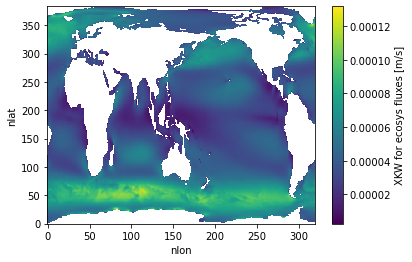

In [25]:
xkw.plot()

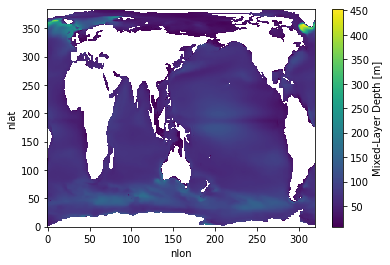

In [26]:
hmxl.plot()

$\tau_{gas} = \frac{\partial DIC}{\partial CO_2}\frac{h}{k_w}$

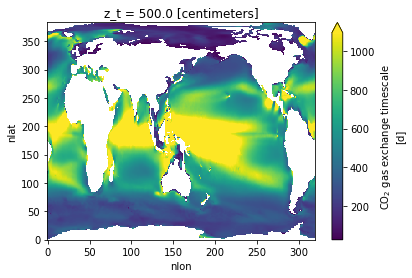

In [30]:
tau_gas.plot(vmax=365*3)

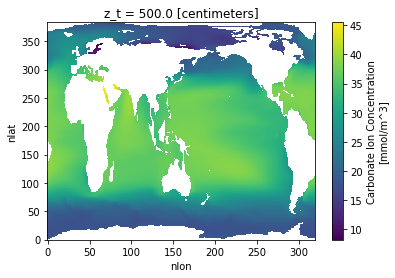

In [31]:
dDICdCO2.plot()